In [19]:
import yfinance as yf
import pandas as pd
from ta import add_all_ta_features
from ta.utils import dropna
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import ta
#import talib
from fracdiff.sklearn import Fracdiff, FracdiffStat
import numpy as np
from advanced_ta import LorentzianClassification
import pandas_ta


In [20]:
ticker = 'AAPL'
aapl = yf.download(ticker, start='2016-01-01', end='2024-01-01')
sp500 = yf.download('^GSPC', start='2016-01-01', end='2024-01-01')
# Align AAPL data with S&P 500 data
aapl['SP500'] = sp500['Close'].reindex(aapl.index).fillna(method='ffill')
aapl['SP500_diff'] = aapl['SP500'].diff()

c:\Conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
c:\Conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_9992\4216808960.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aapl['SP500'] = sp500['Close'].reindex(aapl.index).fillna(method='ffill')


In [21]:
aapl = add_all_ta_features(
    aapl, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)


c:\Conda\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [22]:
aapl['diff'] = aapl['Close'].diff()

In [23]:
aapl['Supertrend7_3'] = pandas_ta.supertrend(aapl['High'], aapl['Low'], aapl['Close'], length=7, multiplier=3)['SUPERT_7_3.0']
aapl['Supertrend10_3'] = pandas_ta.supertrend(aapl['High'], aapl['Low'], aapl['Close'], length=10, multiplier=3)['SUPERT_10_3.0']

aapl['trend_sma_fast-close'] = aapl['trend_sma_fast'] - aapl['Close']
aapl['trend_sma_slow-close'] = aapl['trend_sma_slow'] - aapl['Close']
aapl['trend_ema_fast-close'] = aapl['trend_ema_fast'] - aapl['Close']
aapl['trend_ema_slow-close'] = aapl['trend_ema_slow'] - aapl['Close']
aapl['volatility_bbm-close'] = aapl['volatility_bbm'] - aapl['Close']
aapl['volatility_bbh-close'] = aapl['volatility_bbh'] - aapl['Close']
aapl['volatility_bbl-close'] = aapl['volatility_bbl'] - aapl['Close']
aapl['Supertrend7_3-close'] = aapl['Supertrend7_3'] - aapl['Close']
aapl['Supertrend10_3-close'] = aapl['Supertrend10_3'] - aapl['Close']

stock = yf.download(ticker, period="12y", interval="1d")

stock['open'] = stock['Open']
stock['high'] = stock['High']
stock['low'] = stock['Low']
stock['close'] = stock['Close']
stock['volume'] = stock['Volume']
# df here is the dataframe containing stock data as [['open', 'high', 'low', 'close', 'volume']]. Notice that the column names are in lower case.
lc = LorentzianClassification(
    stock,
    features=[
        LorentzianClassification.Feature("RSI", 21, 2),  # f1
        LorentzianClassification.Feature("WT", 10, 11),  # f2
        LorentzianClassification.Feature("CCI", 20, 2),  # f3
        LorentzianClassification.Feature("ADX", 20, 2),  # f4
        LorentzianClassification.Feature("RSI", 9, 2),   # f5
        
        #MFI(stock['high'], stock['low'], stock['close'], stock['volume'], 14) #f6
    ],
    settings=LorentzianClassification.Settings(
        source=stock['close'],
        neighborsCount=2,
        maxBarsBack=20000,
        useDynamicExits=False
    )
)

aapl = aapl.merge(lc.data[['prediction']],left_index=True, right_index=True, how='left')

C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_9992\430479120.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aapl['Supertrend7_3-close'] = aapl['Supertrend7_3'] - aapl['Close']
C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_9992\430479120.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aapl['Supertrend10_3-close'] = aapl['Supertrend10_3'] - aapl['Close']
c:\Conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future v

In [24]:
aapl.dropna(inplace=True)

In [25]:
fd = FracdiffStat()
for indicator in aapl.columns:
    prob = adfuller(aapl[indicator])[1]
    print(indicator, prob)
    if prob > 0.05 and indicator != "Tomorrow" and indicator != "Target":
        fdindicator = indicator + '_fdiff'
        #pctindicator = indicator + '_pctdiff'
        aapl[fdindicator] = fd.fit_transform(aapl[[indicator]].values)
        #aapl[pctindicator] = aapl[indicator].pct_change()
        aapl.drop(columns=indicator, inplace=True)
aapl = aapl.iloc[6:]
labels = (aapl['diff']>0).tolist()

Open 0.9590679341446294
High 0.951080652835595
Low 0.9495741911839839
Close 0.9456423339343055
Adj Close 0.9512141818459172
Volume 7.926413699085344e-10
SP500 0.8092009423643507
SP500_diff 6.51010360809308e-26
volume_adi 0.5758210099159052
volume_obv 0.3040655129262714
volume_cmf 5.3345487214723876e-08
volume_fi 4.9846057486166907e-11
volume_em 3.2280947898370485e-30
volume_sma_em 1.3488395629442548e-17
volume_vpt 0.4607052659014424
volume_vwap 0.946095750552711
volume_mfi 2.921911343609537e-16
volume_nvi 0.9941938939925323
volatility_bbm 0.9617060055349528
volatility_bbh 0.9392814819763947
volatility_bbl 0.9721743069742713
volatility_bbw 1.1798962760156898e-06
volatility_bbp 1.771656853256769e-16
volatility_bbhi 0.0
volatility_bbli 7.601256602206873e-28
volatility_kcc 0.9512028495012742
volatility_kch 0.9491577212848445
volatility_kcl 0.949549091651654
volatility_kcw 0.0005524787993655666
volatility_kcp 4.073085614397574e-20
volatility_kchi 7.706653853008381e-30
volatility_kcli 2.5971

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(aapl)

In [27]:
sequence_length = 20

# Function to create sequences
def create_sequences(data, labels, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = labels[i+seq_length]
        xs.append(x)
        ys.append(y)
    
    return np.array(xs), np.array(ys)


X_all, y_all = create_sequences(data_scaled, labels, sequence_length)

In [28]:
from sklearn.model_selection import KFold

# Define the number of splits for K-Fold
n_splits = 20
validationLength = 100
# Create the KFold object with the specified number of splits
kf = KFold(n_splits=n_splits)

# Initialize lists to hold the fold data
X_train_folds = []
y_train_folds = []
X_val_folds = []
y_val_folds = []

# Generate the indices for the K-Fold
kf_indices = kf.split(X_all[0:len(X_all) - validationLength])

# Loop through each fold
for train_index, val_index in kf_indices:
    # Generate the training and validation sets for X and y
    X_train, X_val = X_all[train_index], X_all[val_index]
    y_train, y_val = y_all[train_index], y_all[val_index]
    
    # Append the data for this fold to the lists
    X_train_folds.append(X_train)
    y_train_folds.append(y_train)
    X_val_folds.append(X_val)
    y_val_folds.append(y_val)

# Now you have your folds in the _folds lists, and can train and validate your models on them.

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    

In [30]:
def createDataLoader(X_train, y_train, X_val, y_val):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

    # Create the dataset
    traindataset = StockDataset(X_train_tensor, y_train_tensor)

    # Create the DataLoader
    trainLoader = DataLoader(traindataset, batch_size=32, shuffle=False)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    # Create the dataset
    valdataset = StockDataset(X_val_tensor, y_val_tensor)

    # Create the DataLoader
    valLoader = DataLoader(valdataset, batch_size=32, shuffle=False)

  
    return trainLoader, valLoader

In [31]:
import torch.nn as nn

class StockPredictor(nn.Module):
    def __init__(self, num_features, hidden_units, num_layers, dropout_prob = 0.5):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(num_features, hidden_units, num_layers,dropout=dropout_prob, batch_first=True)
        self.fc = nn.Linear(hidden_units, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return torch.sigmoid(out)

num_features = X_train_folds[0].shape[-1]  # Number of features
hidden_units = 250  # Number of hidden units
num_layers = 2  # Number of LSTM layers



In [32]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from typing import Tuple
from sklearn.metrics import accuracy_score

# Assuming 'StockPredictor' is a class derived from nn.Module
# and 'trainLoader' is an instance of DataLoader

def train_model(
    model: nn.Module, 
    train_loader: DataLoader, 
    val_loader: DataLoader, 
    criterion: nn.Module, 
    optimizer: torch.optim.Optimizer, 
    num_epochs: int) -> Tuple[nn.Module, list]:
    """
    Train the model and return the model with the minimum loss.

    Parameters:
    - model: The neural network model to train.
    - train_loader: DataLoader for the training data.
    - criterion: Loss function.
    - optimizer: Optimizer.
    - num_epochs: Number of epochs to train.
    
    Returns:
    - min_loss_model: The model with the minimum loss achieved during training.
    - epoch_loss_history: List of loss values recorded at the end of each epoch.
    """
    min_loss = float('inf')
    minValLoss = float('inf')
    min_loss_model = StockPredictor(num_features, hidden_units, num_layers)  # Assumes these are attributes of your model
    minValLossModel = StockPredictor(num_features, hidden_units, num_layers)
    maxAccuracyModel = StockPredictor(num_features, hidden_units, num_layers)
    train_epoch_loss_history = []
    test_epoch_loss_history = []
    maxaccuracy = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            # Forward pass
            predictions = model(features).squeeze()
            loss = criterion(predictions, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_epoch_loss_history.append(loss.item())
        if loss.item() < min_loss:
            min_loss = loss.item()
            min_loss_model.load_state_dict(model.state_dict())  # Copy model weights
        
        model.eval()
        valPredictions = []
        actuals = []
        validation_loss = 0.0
        with torch.no_grad():  # No need to track the gradients
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                # Forward pass to get output/prediction
                outputs = model(features).squeeze()
                val_loss = criterion(outputs, labels)
                validation_loss += val_loss.item()
                
                # Since we're using sigmoid, we will round the outputs to get the binary class
                predicted_classes = torch.round(outputs)
                
                if predicted_classes.ndim == 0:
                    predicted_classes = predicted_classes.unsqueeze(0)

                # Store valPredictions and actual labels
                valPredictions.extend(predicted_classes.cpu().numpy())
                actuals.extend(labels.cpu().numpy())
        accuracy = accuracy_score(np.array(actuals), np.array(valPredictions))
        validation_loss /= len(val_loader)
        test_epoch_loss_history.append(validation_loss)
        if minValLoss >= validation_loss:
            minValLoss = validation_loss
            minValLossModel.load_state_dict(model.state_dict())
            maxaccuracy = accuracy
        """if maxaccuracy <= accuracy:
            maxAccuracyModel.load_state_dict(model.state_dict())"""
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, minimum Loss: {min_loss:.4f}, accuracy: {accuracy:.4f} maxaccuracy: {maxaccuracy:.4f}  Validation Loss: {validation_loss:.4f}, Minimum Validation Loss: {minValLoss:.4f}')

    return minValLossModel, train_epoch_loss_history,test_epoch_loss_history, maxaccuracy, minValLoss



# minLossModel, loss_history = train_model(model, trainLoader, criterion, optimizer, num_epochs)

In [33]:
import torch
from torch.utils.data import DataLoader

def evaluate_model(model: torch.nn.Module, test_loader: DataLoader) -> Tuple[list, list, list]:
    """
    Evaluate the model on the test set.

    Parameters:
    - model: The trained neural network model for evaluation.
    - test_loader: DataLoader for the test data.

    Returns:
    - probabilities: List of raw output probabilities from the model.
    - predictions: List of predicted classes based on the output probabilities.
    - actuals: List of actual labels.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    
    probabilities = []
    predictions = []
    actuals = []

    with torch.no_grad():  # No need to track the gradients
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            # Forward pass to get output/prediction
            outputs = model(features).squeeze()

            # Since we're using sigmoid, we will round the outputs to get the binary class
            predicted_classes = torch.round(outputs)
            
            # In case of single-element batches, add an extra dimension
            if predicted_classes.ndim == 0:
                predicted_classes = predicted_classes.unsqueeze(0)

            # Store predictions and actual labels
            probabilities.extend(outputs.cpu().numpy())
            predictions.extend(predicted_classes.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    return probabilities, predictions, actuals

# Usage example
# Assuming 'minLossModel' is the trained model and 'testLoader' is defined elsewhere

# probabilities, predictions, actuals = evaluate_model(minLossModel, testLoader)

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, roc_auc_score

def evaluation(predictions, probabilities, actuals, verbose=1, threshold = 0.5):
    probabilities_array = np.array(probabilities)
    predictions_array = (probabilities_array >= threshold).astype(int)
    actuals_array = np.array(actuals)

    # Calculate various classification metrics
    accuracy = accuracy_score(actuals_array, predictions_array)
    precision = precision_score(actuals_array, predictions_array)
    recall = recall_score(actuals_array, predictions_array)
    f1 = f1_score(actuals_array, predictions_array)
    conf_matrix = confusion_matrix(actuals_array, predictions_array)
    auc_score = roc_auc_score(actuals_array, probabilities_array)

    # Print out the metrics
    if verbose:
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print(f'AUC Score: {auc_score:.4f}')
        print(f'Confusion Matrix:\n{conf_matrix}')

In [35]:
from tqdm import tqdm

# Define the model
num_features = X_train_folds[0].shape[-1]  # Number of features
hidden_units = 250  # Number of hidden units
num_layers = 2  # Number of LSTM layers

num_epochs = 300
probabilities, predictions, actuals, train_loss_history, test_loss_history = [], [] ,[], [], []
for i in tqdm(range(len(X_train_folds))):
    print(f'round {i+1}')
    trainLoader, valLoader= createDataLoader(X_train_folds[i],y_train_folds[i],X_val_folds[i],y_val_folds[i])
    accuracy, validationLoss,train_loss_history_tmp, test_loss_history_tmp,i = 0,float('inf'), [],[],0
    
    model = StockPredictor(num_features, hidden_units, num_layers,dropout_prob=0.1)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00002)
    model, train_loss_history_tmp, test_loss_history_tmp,accuracy, validationLoss = train_model(model, trainLoader,valLoader, criterion, optimizer, num_epochs)
    i+=1
    probabilities_tmp, predictions_tmp, actuals_tmp = evaluate_model(model, valLoader)
    probabilities.extend(probabilities_tmp)
    predictions.extend(predictions_tmp)
    actuals.extend(actuals_tmp)
    train_loss_history.append(train_loss_history_tmp)
    test_loss_history.append(test_loss_history_tmp)
    print('threshold = 0.5')
    evaluation(predictions=predictions_tmp, probabilities=probabilities_tmp, actuals=actuals_tmp)
    print('\nthreshold = 0.55')
    evaluation(predictions=predictions_tmp, probabilities=probabilities_tmp, actuals=actuals_tmp, threshold=0.55)

    

  0%|          | 0/20 [00:00<?, ?it/s]

round 1
Epoch [10/300], Loss: 0.6951, minimum Loss: 0.6937, accuracy: 0.5426 maxaccuracy: 0.5426  Validation Loss: 0.6884, Minimum Validation Loss: 0.6884
Epoch [20/300], Loss: 0.6937, minimum Loss: 0.6937, accuracy: 0.5426 maxaccuracy: 0.5426  Validation Loss: 0.6865, Minimum Validation Loss: 0.6865
Epoch [30/300], Loss: 0.6932, minimum Loss: 0.6924, accuracy: 0.5426 maxaccuracy: 0.5426  Validation Loss: 0.6891, Minimum Validation Loss: 0.6865
Epoch [40/300], Loss: 0.6904, minimum Loss: 0.6899, accuracy: 0.5532 maxaccuracy: 0.5426  Validation Loss: 0.6951, Minimum Validation Loss: 0.6865
Epoch [50/300], Loss: 0.6853, minimum Loss: 0.6853, accuracy: 0.5319 maxaccuracy: 0.5426  Validation Loss: 0.7014, Minimum Validation Loss: 0.6865
Epoch [60/300], Loss: 0.6761, minimum Loss: 0.6761, accuracy: 0.5426 maxaccuracy: 0.5426  Validation Loss: 0.7029, Minimum Validation Loss: 0.6865
Epoch [70/300], Loss: 0.6729, minimum Loss: 0.6727, accuracy: 0.5426 maxaccuracy: 0.5426  Validation Loss: 0.7

  5%|▌         | 1/20 [01:37<30:49, 97.33s/it]

Epoch [300/300], Loss: 0.5152, minimum Loss: 0.4713, accuracy: 0.5851 maxaccuracy: 0.5426  Validation Loss: 0.7627, Minimum Validation Loss: 0.6865
threshold = 0.5
Accuracy: 0.5426
Precision: 0.5426
Recall: 1.0000
F1 Score: 0.7034
AUC Score: 0.5641
Confusion Matrix:
[[ 0 43]
 [ 0 51]]

threshold = 0.55
Accuracy: 0.5426
Precision: 0.5667
Recall: 0.6667
F1 Score: 0.6126
AUC Score: 0.5641
Confusion Matrix:
[[17 26]
 [17 34]]
round 2
Epoch [10/300], Loss: 0.6952, minimum Loss: 0.6941, accuracy: 0.5106 maxaccuracy: 0.5106  Validation Loss: 0.6962, Minimum Validation Loss: 0.6938
Epoch [20/300], Loss: 0.6954, minimum Loss: 0.6940, accuracy: 0.5106 maxaccuracy: 0.5106  Validation Loss: 0.7014, Minimum Validation Loss: 0.6938
Epoch [30/300], Loss: 0.6939, minimum Loss: 0.6939, accuracy: 0.5106 maxaccuracy: 0.5106  Validation Loss: 0.7068, Minimum Validation Loss: 0.6938
Epoch [40/300], Loss: 0.6938, minimum Loss: 0.6920, accuracy: 0.5106 maxaccuracy: 0.5106  Validation Loss: 0.7083, Minimum Va

 10%|█         | 2/20 [03:13<29:00, 96.71s/it]

Epoch [300/300], Loss: 0.4730, minimum Loss: 0.4322, accuracy: 0.5319 maxaccuracy: 0.5745  Validation Loss: 0.7567, Minimum Validation Loss: 0.6821
threshold = 0.5
Accuracy: 0.5745
Precision: 0.5833
Recall: 0.5833
F1 Score: 0.5833
AUC Score: 0.5915
Confusion Matrix:
[[26 20]
 [20 28]]

threshold = 0.55
Accuracy: 0.5745
Precision: 0.6538
Recall: 0.3542
F1 Score: 0.4595
AUC Score: 0.5915
Confusion Matrix:
[[37  9]
 [31 17]]
round 3
Epoch [10/300], Loss: 0.6948, minimum Loss: 0.6942, accuracy: 0.6064 maxaccuracy: 0.6064  Validation Loss: 0.6812, Minimum Validation Loss: 0.6812
Epoch [20/300], Loss: 0.6945, minimum Loss: 0.6938, accuracy: 0.6064 maxaccuracy: 0.6064  Validation Loss: 0.6791, Minimum Validation Loss: 0.6791
Epoch [30/300], Loss: 0.6943, minimum Loss: 0.6937, accuracy: 0.6064 maxaccuracy: 0.6064  Validation Loss: 0.6744, Minimum Validation Loss: 0.6744
Epoch [40/300], Loss: 0.6925, minimum Loss: 0.6925, accuracy: 0.6064 maxaccuracy: 0.6064  Validation Loss: 0.6716, Minimum Va

 15%|█▌        | 3/20 [04:52<27:43, 97.84s/it]

Epoch [300/300], Loss: 0.5409, minimum Loss: 0.5045, accuracy: 0.4255 maxaccuracy: 0.6170  Validation Loss: 0.8174, Minimum Validation Loss: 0.6464
threshold = 0.5
Accuracy: 0.6170
Precision: 0.6667
Recall: 0.7368
F1 Score: 0.7000
AUC Score: 0.6268
Confusion Matrix:
[[16 21]
 [15 42]]

threshold = 0.55
Accuracy: 0.5851
Precision: 0.6667
Recall: 0.6316
F1 Score: 0.6486
AUC Score: 0.6268
Confusion Matrix:
[[19 18]
 [21 36]]
round 4
Epoch [10/300], Loss: 0.6944, minimum Loss: 0.6944, accuracy: 0.5319 maxaccuracy: 0.5319  Validation Loss: 0.6907, Minimum Validation Loss: 0.6907
Epoch [20/300], Loss: 0.6932, minimum Loss: 0.6926, accuracy: 0.5319 maxaccuracy: 0.5319  Validation Loss: 0.6912, Minimum Validation Loss: 0.6907
Epoch [30/300], Loss: 0.6914, minimum Loss: 0.6914, accuracy: 0.5319 maxaccuracy: 0.5319  Validation Loss: 0.6914, Minimum Validation Loss: 0.6907
Epoch [40/300], Loss: 0.6894, minimum Loss: 0.6894, accuracy: 0.5319 maxaccuracy: 0.5319  Validation Loss: 0.6905, Minimum Va

 20%|██        | 4/20 [06:30<26:03, 97.69s/it]

Epoch [300/300], Loss: 0.6120, minimum Loss: 0.5397, accuracy: 0.5106 maxaccuracy: 0.5851  Validation Loss: 0.7987, Minimum Validation Loss: 0.6807
threshold = 0.5
Accuracy: 0.5851
Precision: 0.5846
Recall: 0.7600
F1 Score: 0.6609
AUC Score: 0.5859
Confusion Matrix:
[[17 27]
 [12 38]]

threshold = 0.55
Accuracy: 0.5851
Precision: 0.6279
Recall: 0.5400
F1 Score: 0.5806
AUC Score: 0.5859
Confusion Matrix:
[[28 16]
 [23 27]]
round 5
Epoch [10/300], Loss: 0.6942, minimum Loss: 0.6942, accuracy: 0.5213 maxaccuracy: 0.5213  Validation Loss: 0.6928, Minimum Validation Loss: 0.6925
Epoch [20/300], Loss: 0.6940, minimum Loss: 0.6935, accuracy: 0.5213 maxaccuracy: 0.5213  Validation Loss: 0.6932, Minimum Validation Loss: 0.6925
Epoch [30/300], Loss: 0.6937, minimum Loss: 0.6924, accuracy: 0.5213 maxaccuracy: 0.5213  Validation Loss: 0.6949, Minimum Validation Loss: 0.6925
Epoch [40/300], Loss: 0.6930, minimum Loss: 0.6924, accuracy: 0.5213 maxaccuracy: 0.5213  Validation Loss: 0.6959, Minimum Va

 25%|██▌       | 5/20 [08:07<24:22, 97.50s/it]

Epoch [300/300], Loss: 0.6097, minimum Loss: 0.5719, accuracy: 0.5213 maxaccuracy: 0.5213  Validation Loss: 0.7337, Minimum Validation Loss: 0.6836
threshold = 0.5
Accuracy: 0.5213
Precision: 0.5333
Recall: 0.6531
F1 Score: 0.5872
AUC Score: 0.5796
Confusion Matrix:
[[17 28]
 [17 32]]

threshold = 0.55
Accuracy: 0.5851
Precision: 0.6250
Recall: 0.5102
F1 Score: 0.5618
AUC Score: 0.5796
Confusion Matrix:
[[30 15]
 [24 25]]
round 6
Epoch [10/300], Loss: 0.6953, minimum Loss: 0.6937, accuracy: 0.5106 maxaccuracy: 0.5106  Validation Loss: 0.6980, Minimum Validation Loss: 0.6932
Epoch [20/300], Loss: 0.6932, minimum Loss: 0.6923, accuracy: 0.5106 maxaccuracy: 0.5106  Validation Loss: 0.7081, Minimum Validation Loss: 0.6932
Epoch [30/300], Loss: 0.6933, minimum Loss: 0.6922, accuracy: 0.4681 maxaccuracy: 0.5106  Validation Loss: 0.7108, Minimum Validation Loss: 0.6932
Epoch [40/300], Loss: 0.6902, minimum Loss: 0.6895, accuracy: 0.4681 maxaccuracy: 0.5106  Validation Loss: 0.7116, Minimum Va

 30%|███       | 6/20 [09:44<22:42, 97.34s/it]

Epoch [300/300], Loss: 0.5227, minimum Loss: 0.5093, accuracy: 0.5745 maxaccuracy: 0.5851  Validation Loss: 0.7403, Minimum Validation Loss: 0.6717
threshold = 0.5
Accuracy: 0.5851
Precision: 0.6047
Recall: 0.5417
F1 Score: 0.5714
AUC Score: 0.6191
Confusion Matrix:
[[29 17]
 [22 26]]

threshold = 0.55
Accuracy: 0.5638
Precision: 0.6129
Recall: 0.3958
F1 Score: 0.4810
AUC Score: 0.6191
Confusion Matrix:
[[34 12]
 [29 19]]
round 7
Epoch [10/300], Loss: 0.6946, minimum Loss: 0.6935, accuracy: 0.5851 maxaccuracy: 0.5851  Validation Loss: 0.6841, Minimum Validation Loss: 0.6841
Epoch [20/300], Loss: 0.6937, minimum Loss: 0.6931, accuracy: 0.5851 maxaccuracy: 0.5851  Validation Loss: 0.6826, Minimum Validation Loss: 0.6826
Epoch [30/300], Loss: 0.6925, minimum Loss: 0.6924, accuracy: 0.5851 maxaccuracy: 0.5851  Validation Loss: 0.6820, Minimum Validation Loss: 0.6819
Epoch [40/300], Loss: 0.6904, minimum Loss: 0.6902, accuracy: 0.5851 maxaccuracy: 0.5851  Validation Loss: 0.6815, Minimum Va

 35%|███▌      | 7/20 [11:23<21:13, 97.96s/it]

Epoch [300/300], Loss: 0.5634, minimum Loss: 0.4594, accuracy: 0.5106 maxaccuracy: 0.5851  Validation Loss: 0.8114, Minimum Validation Loss: 0.6782
threshold = 0.5
Accuracy: 0.5851
Precision: 0.5851
Recall: 1.0000
F1 Score: 0.7383
AUC Score: 0.5338
Confusion Matrix:
[[ 0 39]
 [ 0 55]]

threshold = 0.55
Accuracy: 0.5638
Precision: 0.5761
Recall: 0.9636
F1 Score: 0.7211
AUC Score: 0.5338
Confusion Matrix:
[[ 0 39]
 [ 2 53]]
round 8
Epoch [10/300], Loss: 0.6957, minimum Loss: 0.6949, accuracy: 0.4787 maxaccuracy: 0.4787  Validation Loss: 0.6966, Minimum Validation Loss: 0.6948
Epoch [20/300], Loss: 0.6937, minimum Loss: 0.6935, accuracy: 0.4787 maxaccuracy: 0.4787  Validation Loss: 0.6975, Minimum Validation Loss: 0.6948
Epoch [30/300], Loss: 0.6943, minimum Loss: 0.6932, accuracy: 0.4787 maxaccuracy: 0.4787  Validation Loss: 0.7000, Minimum Validation Loss: 0.6948
Epoch [40/300], Loss: 0.6909, minimum Loss: 0.6899, accuracy: 0.4787 maxaccuracy: 0.4787  Validation Loss: 0.7034, Minimum Va

c:\Conda\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 40%|████      | 8/20 [13:01<19:36, 98.01s/it]

Epoch [300/300], Loss: 0.5567, minimum Loss: 0.5089, accuracy: 0.4362 maxaccuracy: 0.4787  Validation Loss: 1.2332, Minimum Validation Loss: 0.6948
threshold = 0.5
Accuracy: 0.4787
Precision: 0.4787
Recall: 1.0000
F1 Score: 0.6475
AUC Score: 0.5365
Confusion Matrix:
[[ 0 49]
 [ 0 45]]

threshold = 0.55
Accuracy: 0.5213
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC Score: 0.5365
Confusion Matrix:
[[49  0]
 [45  0]]
round 9
Epoch [10/300], Loss: 0.6956, minimum Loss: 0.6944, accuracy: 0.5532 maxaccuracy: 0.5532  Validation Loss: 0.6873, Minimum Validation Loss: 0.6873
Epoch [20/300], Loss: 0.6941, minimum Loss: 0.6932, accuracy: 0.5532 maxaccuracy: 0.5532  Validation Loss: 0.6852, Minimum Validation Loss: 0.6852
Epoch [30/300], Loss: 0.6942, minimum Loss: 0.6925, accuracy: 0.5532 maxaccuracy: 0.5532  Validation Loss: 0.6825, Minimum Validation Loss: 0.6825
Epoch [40/300], Loss: 0.6938, minimum Loss: 0.6925, accuracy: 0.5532 maxaccuracy: 0.5532  Validation Loss: 0.6802, Minimum Va

 45%|████▌     | 9/20 [14:42<18:05, 98.70s/it]

Epoch [300/300], Loss: 0.5533, minimum Loss: 0.4970, accuracy: 0.5319 maxaccuracy: 0.5319  Validation Loss: 0.7593, Minimum Validation Loss: 0.6553
threshold = 0.5
Accuracy: 0.5319
Precision: 0.5909
Recall: 0.5000
F1 Score: 0.5417
AUC Score: 0.6424
Confusion Matrix:
[[24 18]
 [26 26]]

threshold = 0.55
Accuracy: 0.5426
Precision: 0.6800
Recall: 0.3269
F1 Score: 0.4416
AUC Score: 0.6424
Confusion Matrix:
[[34  8]
 [35 17]]
round 10
Epoch [10/300], Loss: 0.6943, minimum Loss: 0.6934, accuracy: 0.5851 maxaccuracy: 0.5851  Validation Loss: 0.6837, Minimum Validation Loss: 0.6837
Epoch [20/300], Loss: 0.6934, minimum Loss: 0.6932, accuracy: 0.5851 maxaccuracy: 0.5851  Validation Loss: 0.6821, Minimum Validation Loss: 0.6821
Epoch [30/300], Loss: 0.6945, minimum Loss: 0.6928, accuracy: 0.5851 maxaccuracy: 0.5851  Validation Loss: 0.6811, Minimum Validation Loss: 0.6811
Epoch [40/300], Loss: 0.6929, minimum Loss: 0.6917, accuracy: 0.5851 maxaccuracy: 0.5851  Validation Loss: 0.6806, Minimum V

 50%|█████     | 10/20 [16:21<16:28, 98.89s/it]

Epoch [300/300], Loss: 0.6199, minimum Loss: 0.6013, accuracy: 0.5532 maxaccuracy: 0.5851  Validation Loss: 0.7884, Minimum Validation Loss: 0.6789
threshold = 0.5
Accuracy: 0.5851
Precision: 0.5851
Recall: 1.0000
F1 Score: 0.7383
AUC Score: 0.5119
Confusion Matrix:
[[ 0 39]
 [ 0 55]]

threshold = 0.55
Accuracy: 0.5532
Precision: 0.5890
Recall: 0.7818
F1 Score: 0.6719
AUC Score: 0.5119
Confusion Matrix:
[[ 9 30]
 [12 43]]
round 11
Epoch [10/300], Loss: 0.6948, minimum Loss: 0.6930, accuracy: 0.5000 maxaccuracy: 0.5000  Validation Loss: 0.6955, Minimum Validation Loss: 0.6927
Epoch [20/300], Loss: 0.6942, minimum Loss: 0.6927, accuracy: 0.5000 maxaccuracy: 0.5000  Validation Loss: 0.6972, Minimum Validation Loss: 0.6927
Epoch [30/300], Loss: 0.6924, minimum Loss: 0.6922, accuracy: 0.5000 maxaccuracy: 0.5000  Validation Loss: 0.6972, Minimum Validation Loss: 0.6927
Epoch [40/300], Loss: 0.6919, minimum Loss: 0.6897, accuracy: 0.5426 maxaccuracy: 0.5000  Validation Loss: 0.6971, Minimum V

 55%|█████▌    | 11/20 [17:59<14:48, 98.67s/it]

Epoch [300/300], Loss: 0.5892, minimum Loss: 0.5602, accuracy: 0.6170 maxaccuracy: 0.5745  Validation Loss: 0.8526, Minimum Validation Loss: 0.6889
threshold = 0.5
Accuracy: 0.5745
Precision: 0.5745
Recall: 0.5745
F1 Score: 0.5745
AUC Score: 0.5817
Confusion Matrix:
[[27 20]
 [20 27]]

threshold = 0.55
Accuracy: 0.5745
Precision: 0.5946
Recall: 0.4681
F1 Score: 0.5238
AUC Score: 0.5817
Confusion Matrix:
[[32 15]
 [25 22]]
round 12
Epoch [10/300], Loss: 0.6939, minimum Loss: 0.6930, accuracy: 0.6170 maxaccuracy: 0.6170  Validation Loss: 0.6822, Minimum Validation Loss: 0.6821
Epoch [20/300], Loss: 0.6939, minimum Loss: 0.6930, accuracy: 0.6064 maxaccuracy: 0.6170  Validation Loss: 0.6835, Minimum Validation Loss: 0.6821
Epoch [30/300], Loss: 0.6929, minimum Loss: 0.6928, accuracy: 0.5426 maxaccuracy: 0.6170  Validation Loss: 0.6838, Minimum Validation Loss: 0.6821
Epoch [40/300], Loss: 0.6857, minimum Loss: 0.6857, accuracy: 0.5426 maxaccuracy: 0.6170  Validation Loss: 0.6833, Minimum V

 60%|██████    | 12/20 [19:35<13:03, 97.88s/it]

Epoch [300/300], Loss: 0.4636, minimum Loss: 0.4243, accuracy: 0.4574 maxaccuracy: 0.6064  Validation Loss: 0.8345, Minimum Validation Loss: 0.6815
threshold = 0.5
Accuracy: 0.6064
Precision: 0.6522
Recall: 0.7759
F1 Score: 0.7087
AUC Score: 0.5800
Confusion Matrix:
[[12 24]
 [13 45]]

threshold = 0.55
Accuracy: 0.4574
Precision: 0.7333
Recall: 0.1897
F1 Score: 0.3014
AUC Score: 0.5800
Confusion Matrix:
[[32  4]
 [47 11]]
round 13
Epoch [10/300], Loss: 0.6944, minimum Loss: 0.6923, accuracy: 0.5319 maxaccuracy: 0.5319  Validation Loss: 0.6916, Minimum Validation Loss: 0.6915
Epoch [20/300], Loss: 0.6925, minimum Loss: 0.6923, accuracy: 0.5426 maxaccuracy: 0.5319  Validation Loss: 0.6919, Minimum Validation Loss: 0.6915
Epoch [30/300], Loss: 0.6950, minimum Loss: 0.6923, accuracy: 0.4787 maxaccuracy: 0.5319  Validation Loss: 0.6930, Minimum Validation Loss: 0.6915
Epoch [40/300], Loss: 0.6944, minimum Loss: 0.6908, accuracy: 0.4894 maxaccuracy: 0.5319  Validation Loss: 0.6955, Minimum V

c:\Conda\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 65%|██████▌   | 13/20 [21:12<11:23, 97.71s/it]

Epoch [300/300], Loss: 0.5230, minimum Loss: 0.4788, accuracy: 0.4574 maxaccuracy: 0.5319  Validation Loss: 0.8884, Minimum Validation Loss: 0.6915
threshold = 0.5
Accuracy: 0.5319
Precision: 0.5319
Recall: 1.0000
F1 Score: 0.6944
AUC Score: 0.4700
Confusion Matrix:
[[ 0 44]
 [ 0 50]]

threshold = 0.55
Accuracy: 0.4681
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC Score: 0.4700
Confusion Matrix:
[[44  0]
 [50  0]]
round 14
Epoch [10/300], Loss: 0.6955, minimum Loss: 0.6935, accuracy: 0.4894 maxaccuracy: 0.4894  Validation Loss: 0.6961, Minimum Validation Loss: 0.6937
Epoch [20/300], Loss: 0.6940, minimum Loss: 0.6935, accuracy: 0.4894 maxaccuracy: 0.4894  Validation Loss: 0.6935, Minimum Validation Loss: 0.6935
Epoch [30/300], Loss: 0.6928, minimum Loss: 0.6928, accuracy: 0.4787 maxaccuracy: 0.4787  Validation Loss: 0.6896, Minimum Validation Loss: 0.6896
Epoch [40/300], Loss: 0.6909, minimum Loss: 0.6909, accuracy: 0.5319 maxaccuracy: 0.5319  Validation Loss: 0.6870, Minimum V

 70%|███████   | 14/20 [22:52<09:50, 98.37s/it]

Epoch [300/300], Loss: 0.6261, minimum Loss: 0.5898, accuracy: 0.5638 maxaccuracy: 0.5319  Validation Loss: 0.8046, Minimum Validation Loss: 0.6849
threshold = 0.5
Accuracy: 0.5319
Precision: 0.5167
Recall: 0.6739
F1 Score: 0.5849
AUC Score: 0.5996
Confusion Matrix:
[[19 29]
 [15 31]]

threshold = 0.55
Accuracy: 0.5532
Precision: 0.5417
Recall: 0.5652
F1 Score: 0.5532
AUC Score: 0.5996
Confusion Matrix:
[[26 22]
 [20 26]]
round 15
Epoch [10/300], Loss: 0.6945, minimum Loss: 0.6938, accuracy: 0.5426 maxaccuracy: 0.5426  Validation Loss: 0.6898, Minimum Validation Loss: 0.6898
Epoch [20/300], Loss: 0.6935, minimum Loss: 0.6931, accuracy: 0.5426 maxaccuracy: 0.5426  Validation Loss: 0.6898, Minimum Validation Loss: 0.6898
Epoch [30/300], Loss: 0.6930, minimum Loss: 0.6921, accuracy: 0.4681 maxaccuracy: 0.4681  Validation Loss: 0.6883, Minimum Validation Loss: 0.6883
Epoch [40/300], Loss: 0.6922, minimum Loss: 0.6914, accuracy: 0.4787 maxaccuracy: 0.4787  Validation Loss: 0.6868, Minimum V

 75%|███████▌  | 15/20 [24:28<08:07, 97.51s/it]

Epoch [300/300], Loss: 0.4937, minimum Loss: 0.4126, accuracy: 0.5106 maxaccuracy: 0.5213  Validation Loss: 0.8831, Minimum Validation Loss: 0.6864
threshold = 0.5
Accuracy: 0.5213
Precision: 0.5441
Recall: 0.7255
F1 Score: 0.6218
AUC Score: 0.5554
Confusion Matrix:
[[12 31]
 [14 37]]

threshold = 0.55
Accuracy: 0.5213
Precision: 0.6500
Recall: 0.2549
F1 Score: 0.3662
AUC Score: 0.5554
Confusion Matrix:
[[36  7]
 [38 13]]
round 16
Epoch [10/300], Loss: 0.6941, minimum Loss: 0.6940, accuracy: 0.5106 maxaccuracy: 0.5106  Validation Loss: 0.6930, Minimum Validation Loss: 0.6930
Epoch [20/300], Loss: 0.6940, minimum Loss: 0.6934, accuracy: 0.5426 maxaccuracy: 0.5426  Validation Loss: 0.6902, Minimum Validation Loss: 0.6902
Epoch [30/300], Loss: 0.6960, minimum Loss: 0.6923, accuracy: 0.5851 maxaccuracy: 0.5851  Validation Loss: 0.6870, Minimum Validation Loss: 0.6870
Epoch [40/300], Loss: 0.6931, minimum Loss: 0.6922, accuracy: 0.5957 maxaccuracy: 0.5957  Validation Loss: 0.6834, Minimum V

 80%|████████  | 16/20 [26:00<06:23, 95.77s/it]

Epoch [300/300], Loss: 0.5832, minimum Loss: 0.5012, accuracy: 0.5319 maxaccuracy: 0.5532  Validation Loss: 0.8158, Minimum Validation Loss: 0.6751
threshold = 0.5
Accuracy: 0.5532
Precision: 0.5577
Recall: 0.6042
F1 Score: 0.5800
AUC Score: 0.6087
Confusion Matrix:
[[23 23]
 [19 29]]

threshold = 0.55
Accuracy: 0.5745
Precision: 0.6333
Recall: 0.3958
F1 Score: 0.4872
AUC Score: 0.6087
Confusion Matrix:
[[35 11]
 [29 19]]
round 17
Epoch [10/300], Loss: 0.6978, minimum Loss: 0.6961, accuracy: 0.4946 maxaccuracy: 0.4946  Validation Loss: 0.6960, Minimum Validation Loss: 0.6947
Epoch [20/300], Loss: 0.6938, minimum Loss: 0.6938, accuracy: 0.4946 maxaccuracy: 0.4946  Validation Loss: 0.6957, Minimum Validation Loss: 0.6947
Epoch [30/300], Loss: 0.6913, minimum Loss: 0.6913, accuracy: 0.4839 maxaccuracy: 0.4946  Validation Loss: 0.6990, Minimum Validation Loss: 0.6947
Epoch [40/300], Loss: 0.6908, minimum Loss: 0.6901, accuracy: 0.4731 maxaccuracy: 0.4946  Validation Loss: 0.7032, Minimum V

c:\Conda\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 85%|████████▌ | 17/20 [27:31<04:43, 94.57s/it]

Epoch [300/300], Loss: 0.5138, minimum Loss: 0.5138, accuracy: 0.4516 maxaccuracy: 0.4946  Validation Loss: 1.2551, Minimum Validation Loss: 0.6947
threshold = 0.5
Accuracy: 0.4946
Precision: 0.4946
Recall: 1.0000
F1 Score: 0.6619
AUC Score: 0.5319
Confusion Matrix:
[[ 0 47]
 [ 0 46]]

threshold = 0.55
Accuracy: 0.5054
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC Score: 0.5319
Confusion Matrix:
[[47  0]
 [46  0]]
round 18
Epoch [10/300], Loss: 0.7005, minimum Loss: 0.6968, accuracy: 0.4946 maxaccuracy: 0.4946  Validation Loss: 0.6970, Minimum Validation Loss: 0.6953
Epoch [20/300], Loss: 0.6981, minimum Loss: 0.6968, accuracy: 0.4946 maxaccuracy: 0.4946  Validation Loss: 0.6950, Minimum Validation Loss: 0.6950
Epoch [30/300], Loss: 0.6954, minimum Loss: 0.6941, accuracy: 0.5376 maxaccuracy: 0.5376  Validation Loss: 0.6914, Minimum Validation Loss: 0.6914
Epoch [40/300], Loss: 0.6913, minimum Loss: 0.6901, accuracy: 0.5269 maxaccuracy: 0.5269  Validation Loss: 0.6900, Minimum V

 90%|█████████ | 18/20 [29:03<03:07, 93.55s/it]

Epoch [300/300], Loss: 0.5568, minimum Loss: 0.4780, accuracy: 0.5591 maxaccuracy: 0.5699  Validation Loss: 0.8075, Minimum Validation Loss: 0.6891
threshold = 0.5
Accuracy: 0.5699
Precision: 0.5536
Recall: 0.6739
F1 Score: 0.6078
AUC Score: 0.5671
Confusion Matrix:
[[22 25]
 [15 31]]

threshold = 0.55
Accuracy: 0.5699
Precision: 0.5750
Recall: 0.5000
F1 Score: 0.5349
AUC Score: 0.5671
Confusion Matrix:
[[30 17]
 [23 23]]
round 19
Epoch [10/300], Loss: 0.6986, minimum Loss: 0.6948, accuracy: 0.5484 maxaccuracy: 0.5484  Validation Loss: 0.6883, Minimum Validation Loss: 0.6883
Epoch [20/300], Loss: 0.6942, minimum Loss: 0.6942, accuracy: 0.5484 maxaccuracy: 0.5484  Validation Loss: 0.6885, Minimum Validation Loss: 0.6882
Epoch [30/300], Loss: 0.6916, minimum Loss: 0.6916, accuracy: 0.5161 maxaccuracy: 0.5484  Validation Loss: 0.6906, Minimum Validation Loss: 0.6882
Epoch [40/300], Loss: 0.6896, minimum Loss: 0.6892, accuracy: 0.5054 maxaccuracy: 0.5484  Validation Loss: 0.6954, Minimum V

c:\Conda\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 95%|█████████▌| 19/20 [30:34<01:32, 92.98s/it]

Epoch [300/300], Loss: 0.5214, minimum Loss: 0.4859, accuracy: 0.3978 maxaccuracy: 0.5484  Validation Loss: 0.8627, Minimum Validation Loss: 0.6882
threshold = 0.5
Accuracy: 0.5484
Precision: 0.5484
Recall: 1.0000
F1 Score: 0.7083
AUC Score: 0.5514
Confusion Matrix:
[[ 0 42]
 [ 0 51]]

threshold = 0.55
Accuracy: 0.4516
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC Score: 0.5514
Confusion Matrix:
[[42  0]
 [51  0]]
round 20
Epoch [10/300], Loss: 0.6755, minimum Loss: 0.6740, accuracy: 0.5054 maxaccuracy: 0.5054  Validation Loss: 0.6951, Minimum Validation Loss: 0.6935
Epoch [20/300], Loss: 0.6806, minimum Loss: 0.6740, accuracy: 0.5054 maxaccuracy: 0.5054  Validation Loss: 0.6935, Minimum Validation Loss: 0.6935
Epoch [30/300], Loss: 0.6860, minimum Loss: 0.6740, accuracy: 0.5269 maxaccuracy: 0.5269  Validation Loss: 0.6919, Minimum Validation Loss: 0.6919
Epoch [40/300], Loss: 0.6852, minimum Loss: 0.6740, accuracy: 0.5591 maxaccuracy: 0.5591  Validation Loss: 0.6901, Minimum V

100%|██████████| 20/20 [32:06<00:00, 96.34s/it]

Epoch [300/300], Loss: 0.5659, minimum Loss: 0.5132, accuracy: 0.4946 maxaccuracy: 0.5914  Validation Loss: 0.8055, Minimum Validation Loss: 0.6846
threshold = 0.5
Accuracy: 0.5914
Precision: 0.5789
Recall: 0.7021
F1 Score: 0.6346
AUC Score: 0.5726
Confusion Matrix:
[[22 24]
 [14 33]]

threshold = 0.55
Accuracy: 0.5269
Precision: 0.6000
Recall: 0.1915
F1 Score: 0.2903
AUC Score: 0.5726
Confusion Matrix:
[[40  6]
 [38  9]]


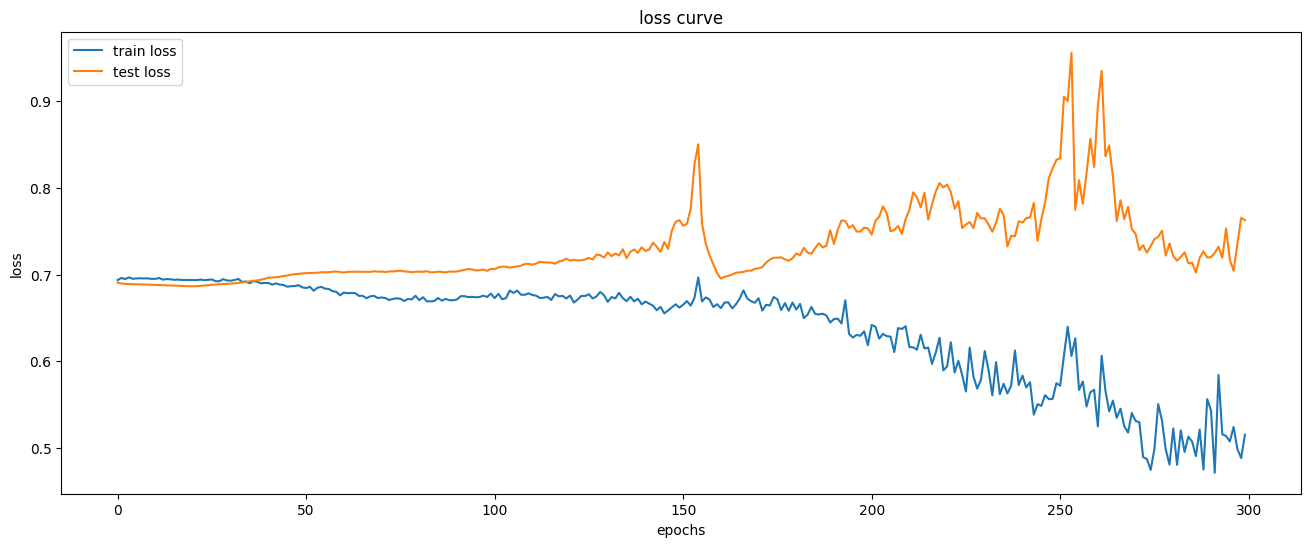

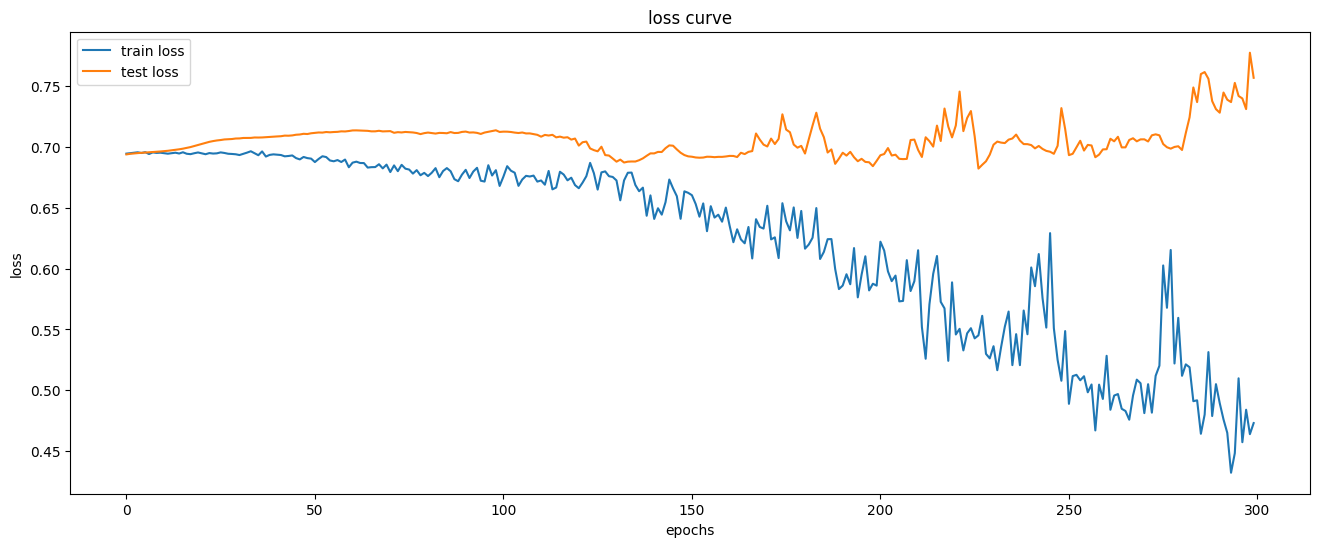

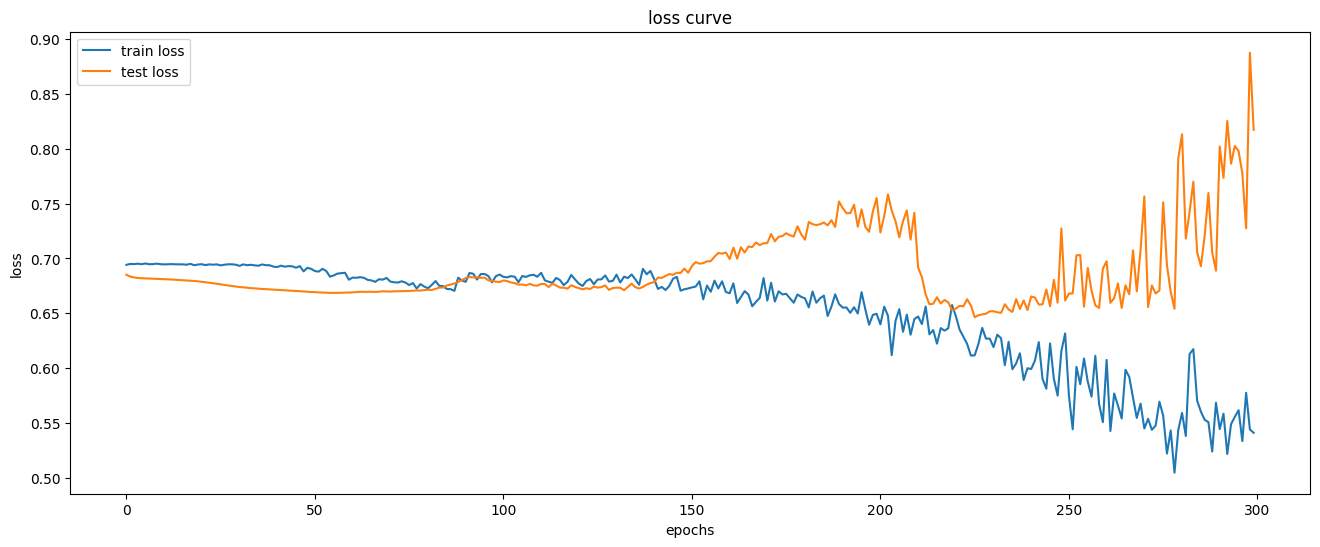

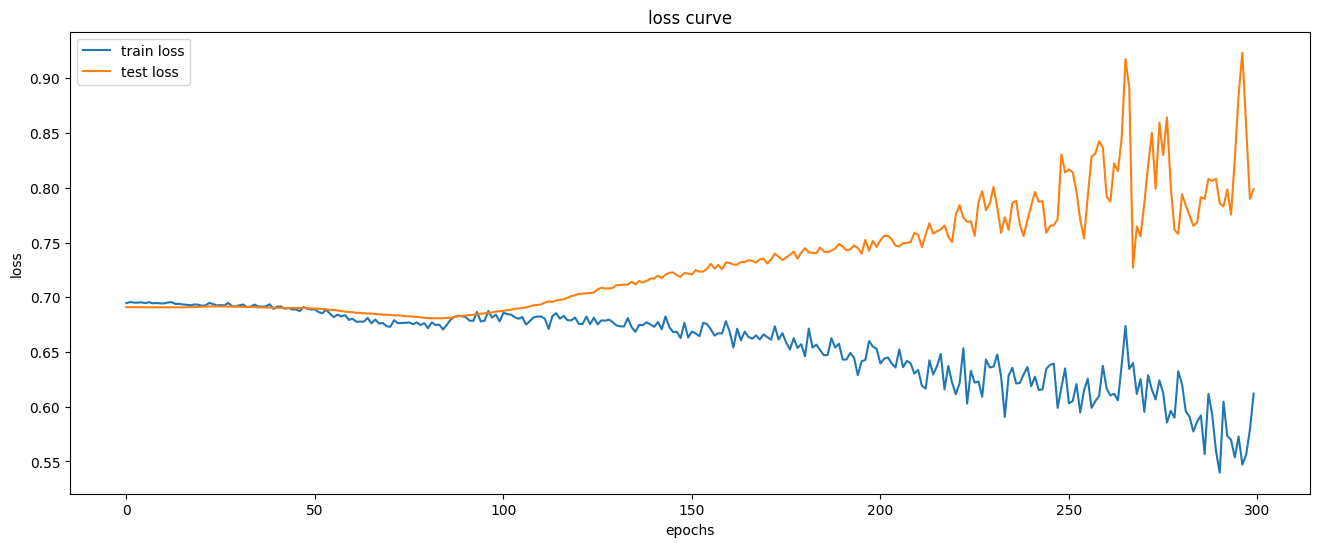

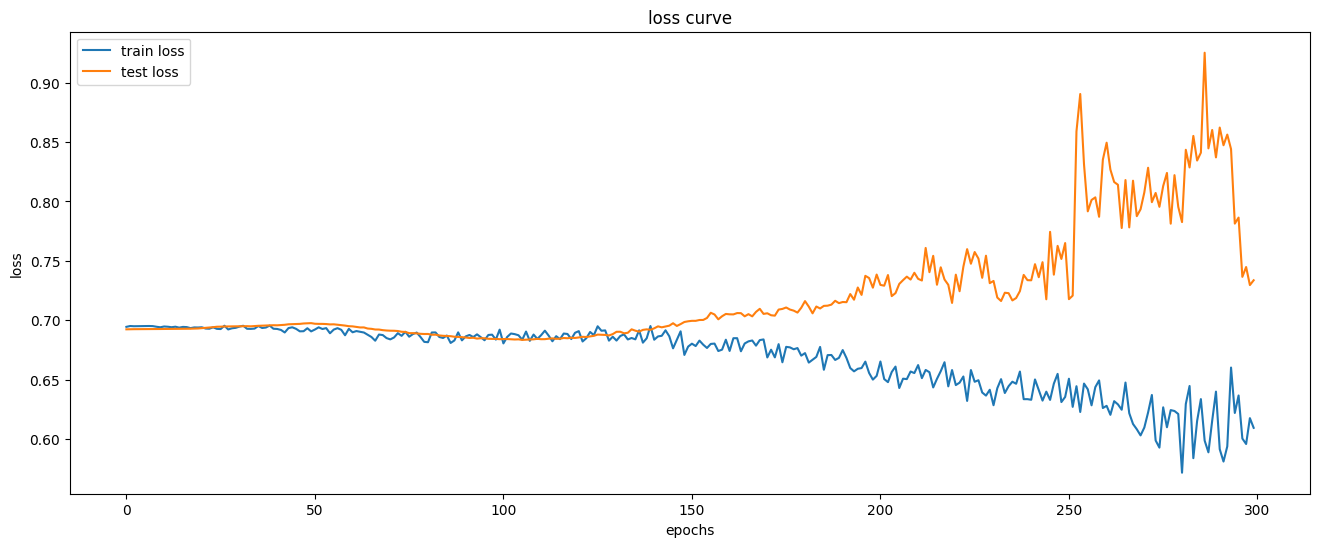

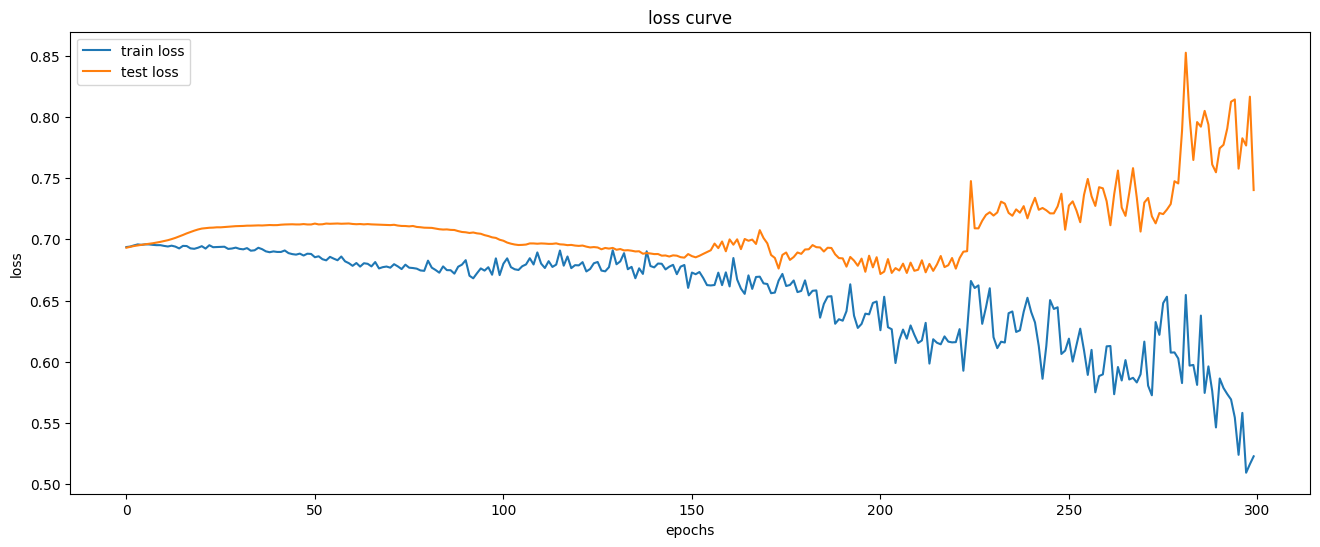

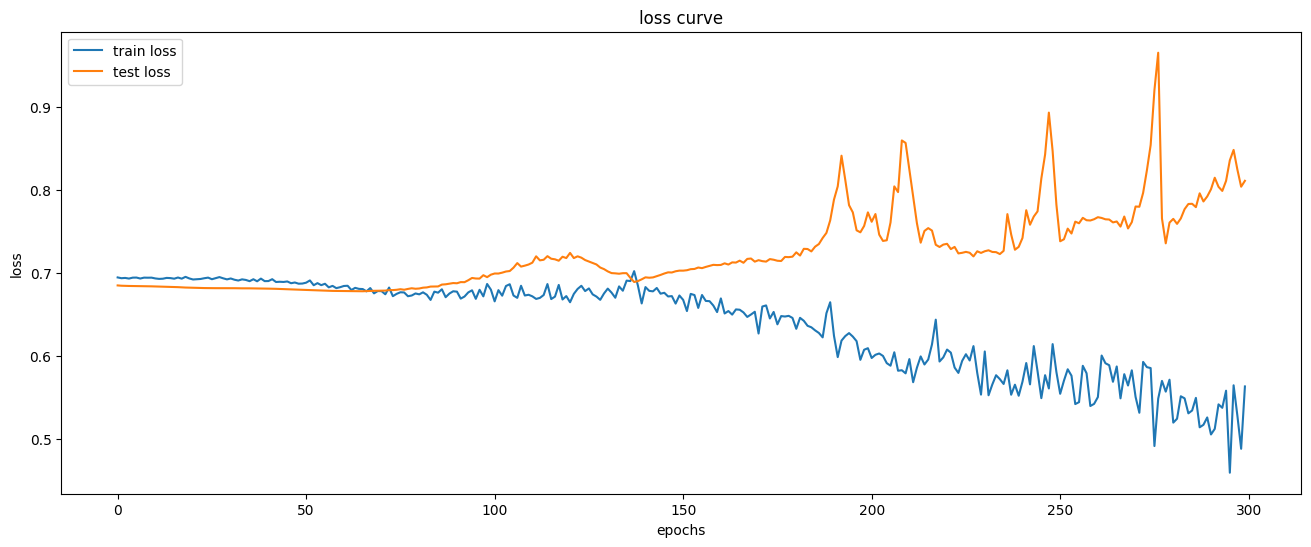

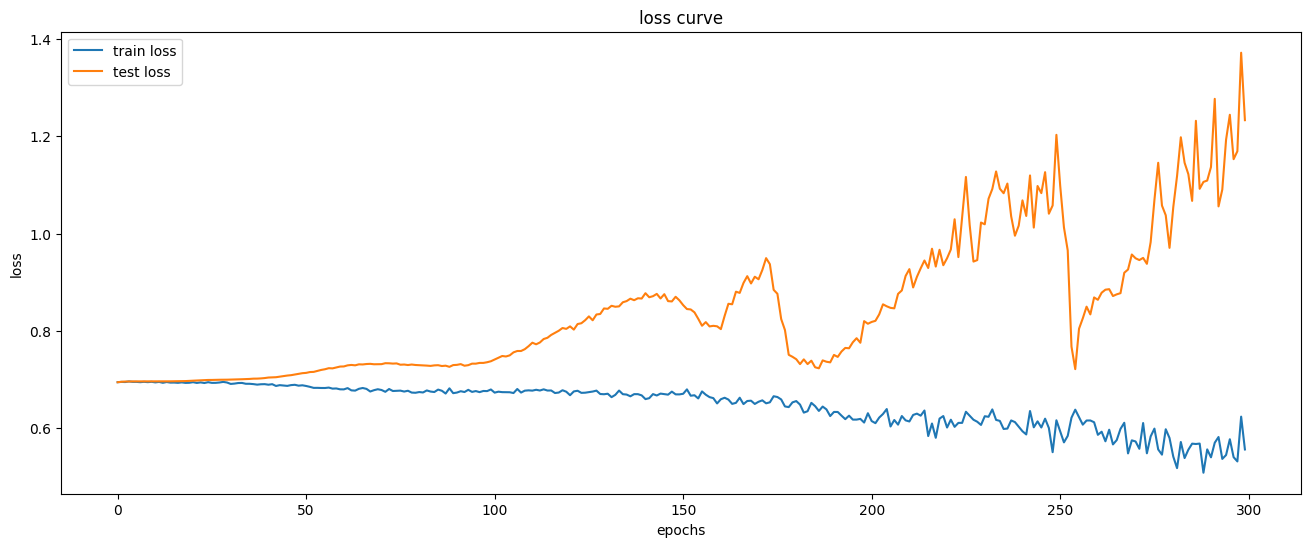

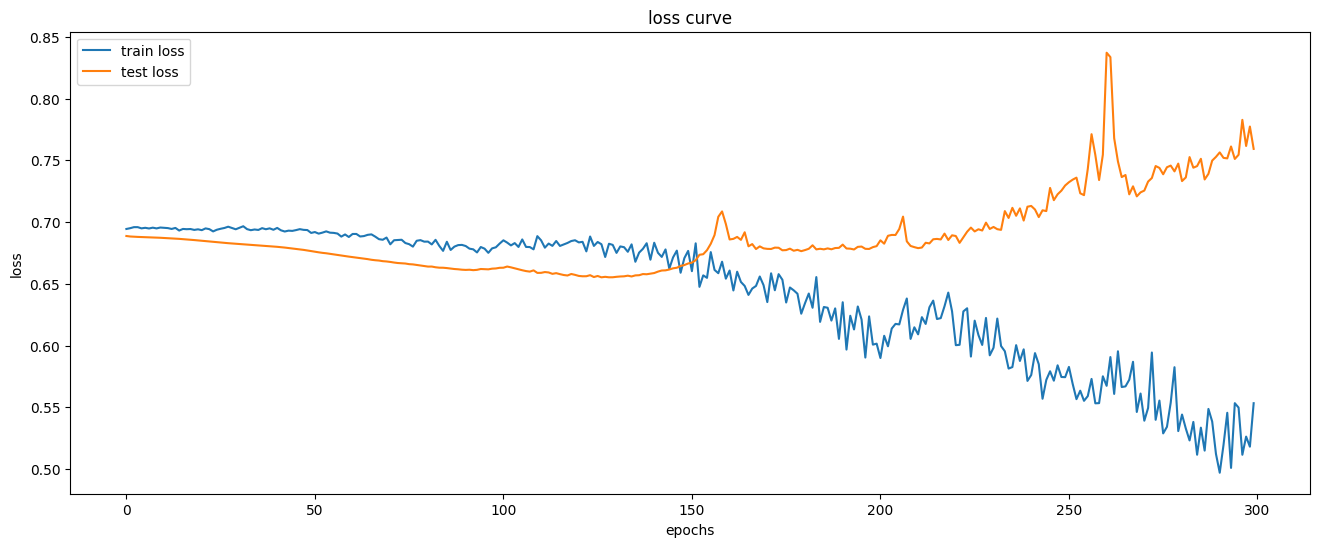

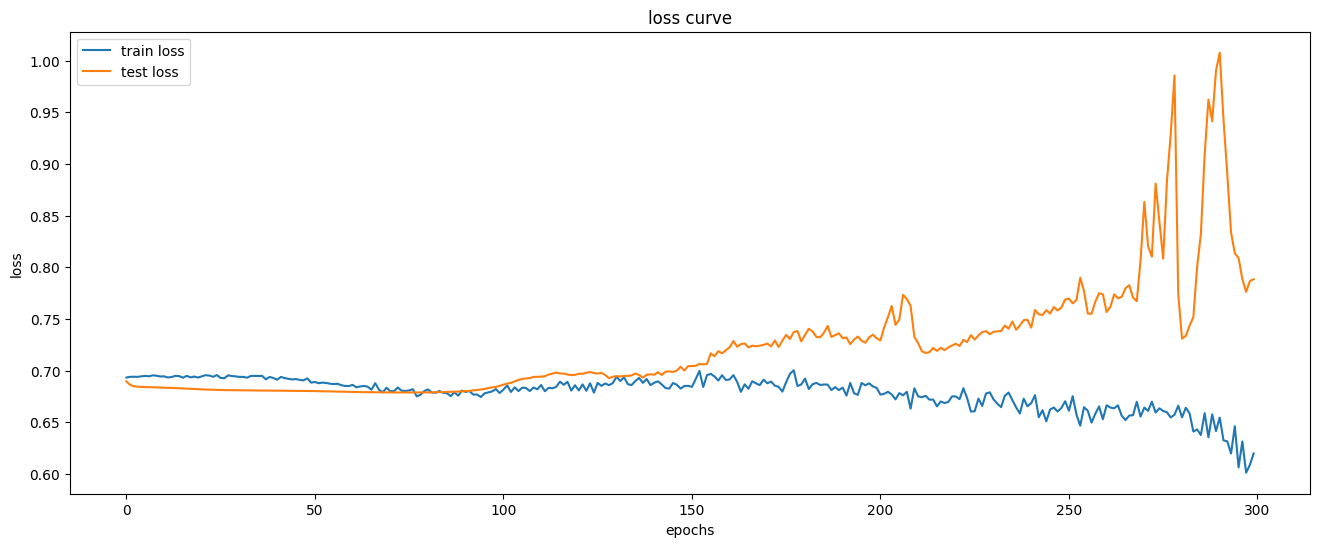

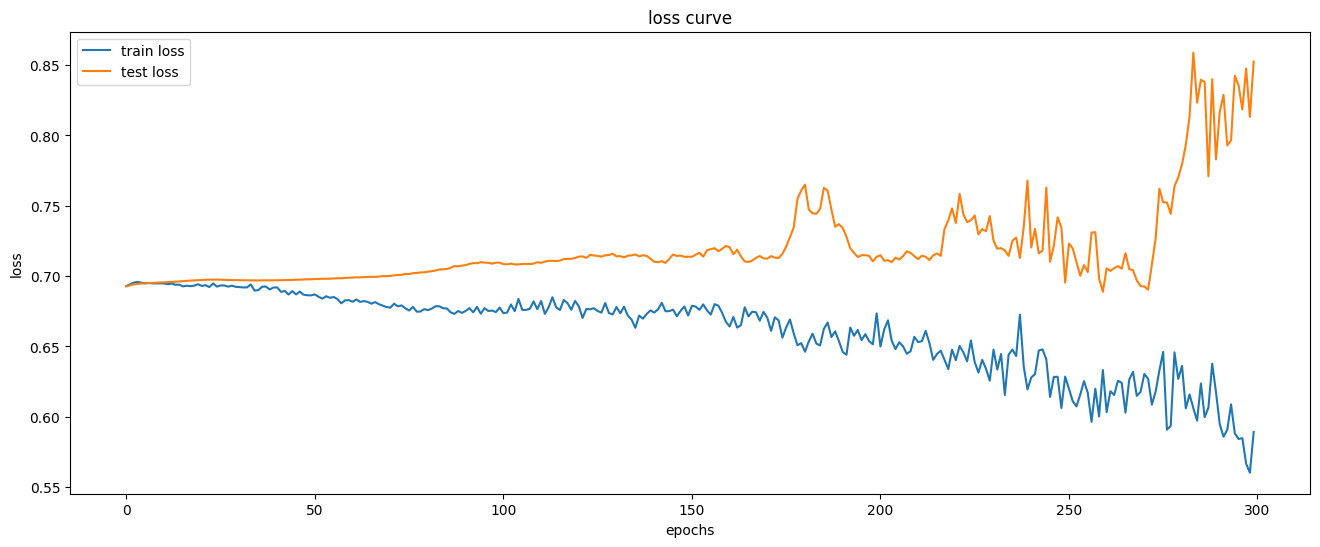

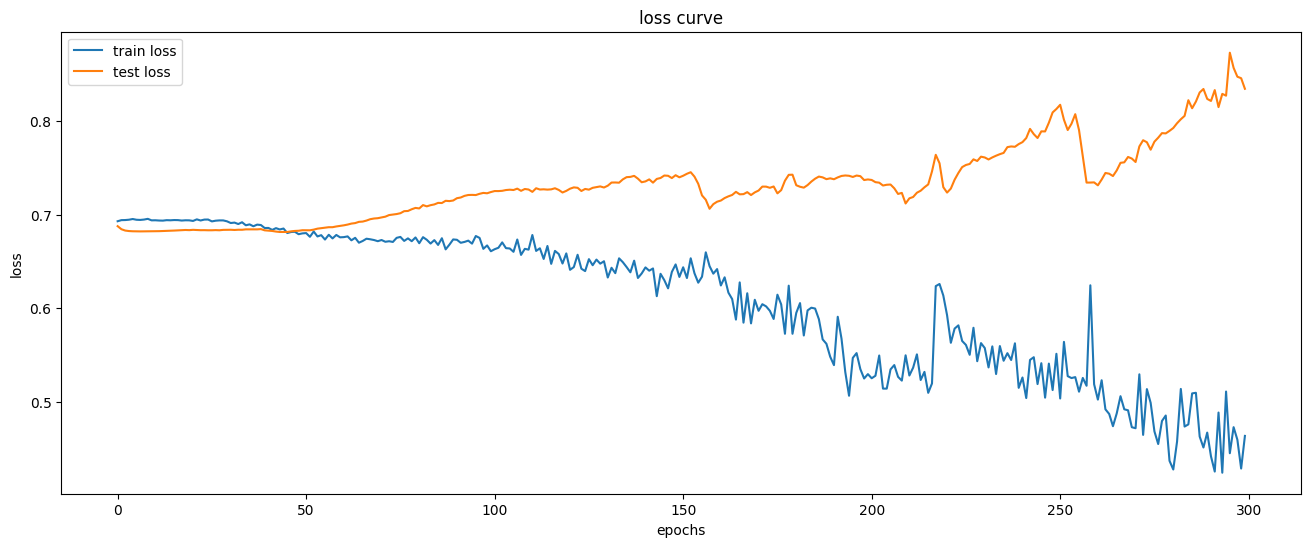

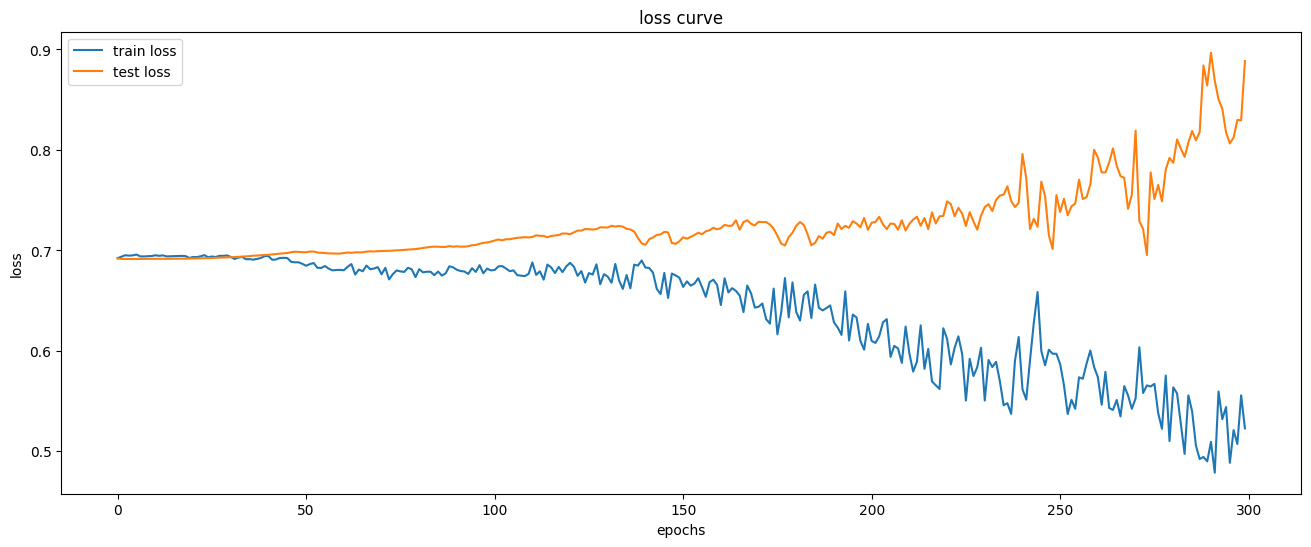

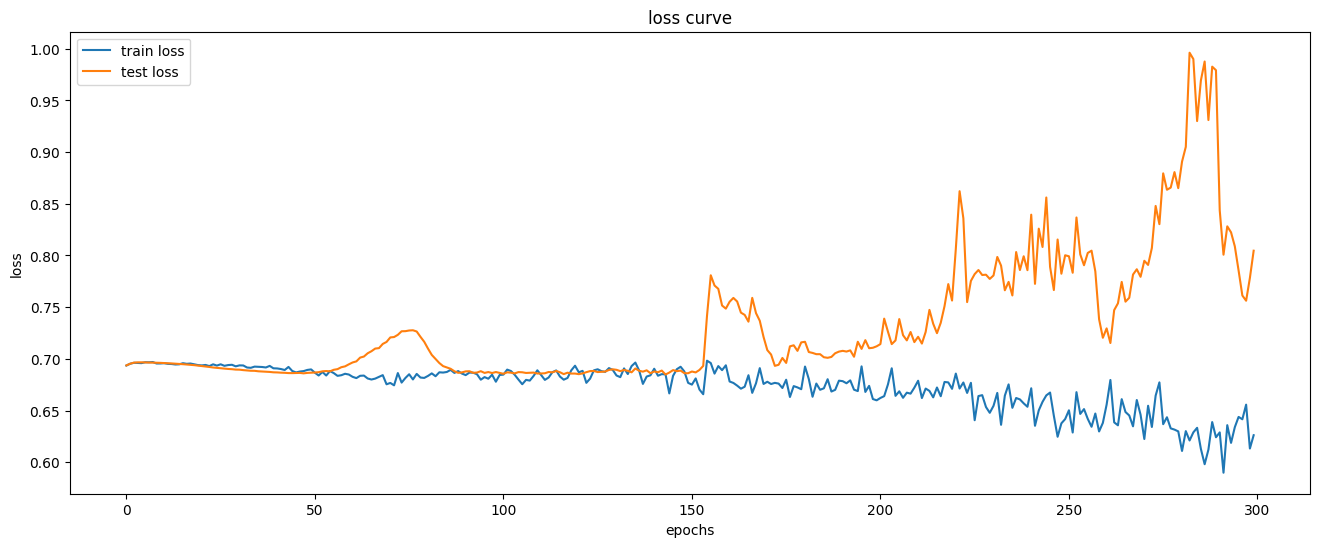

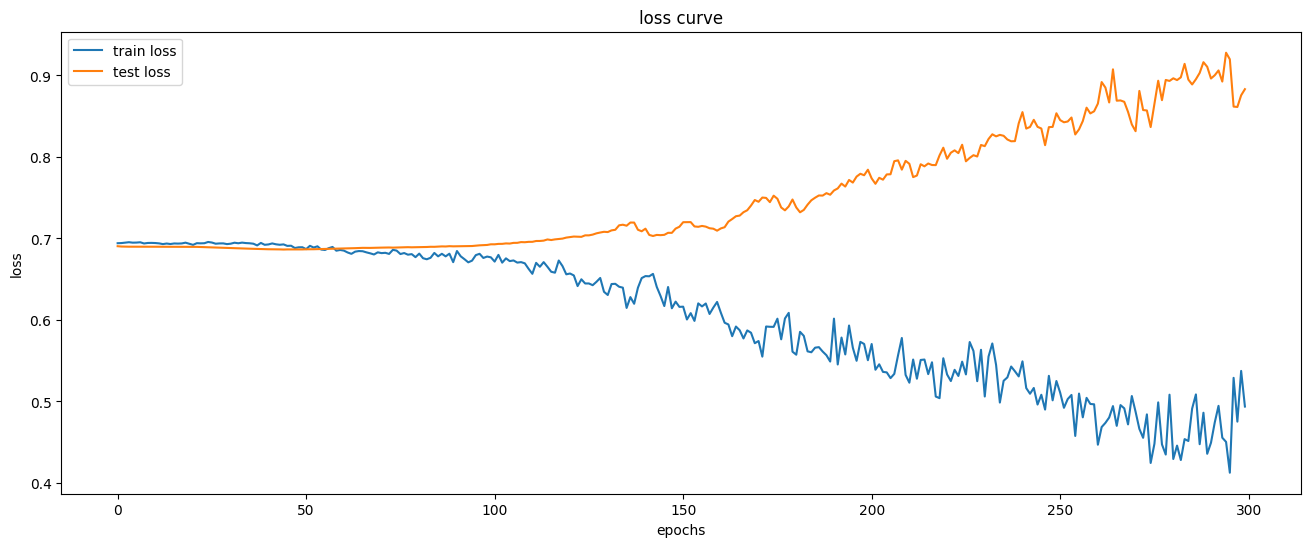

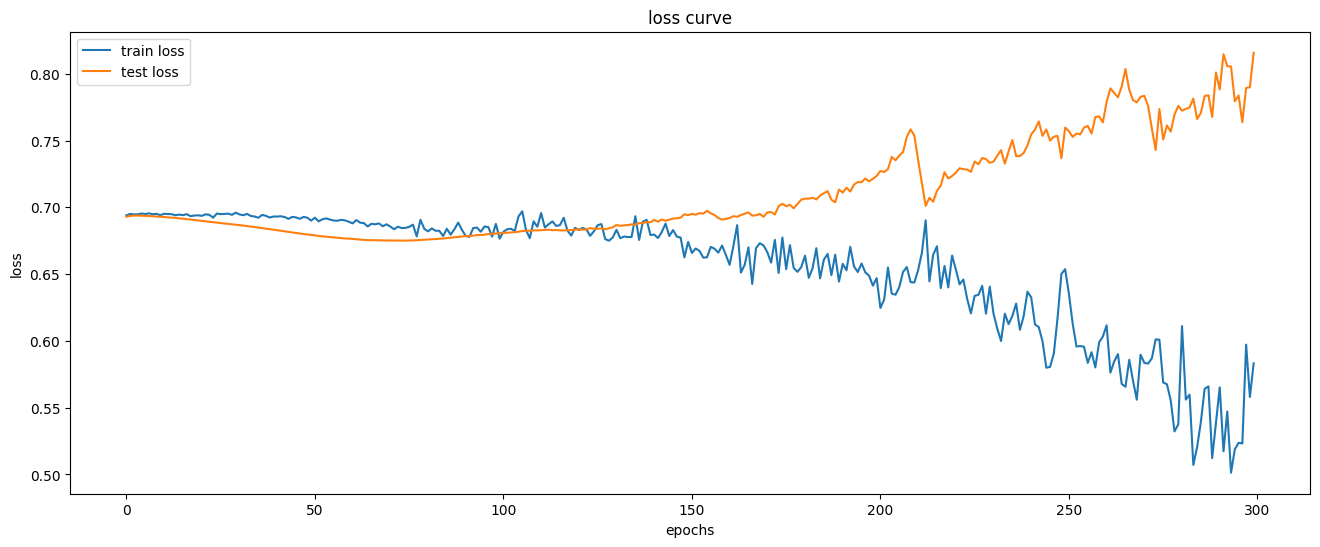

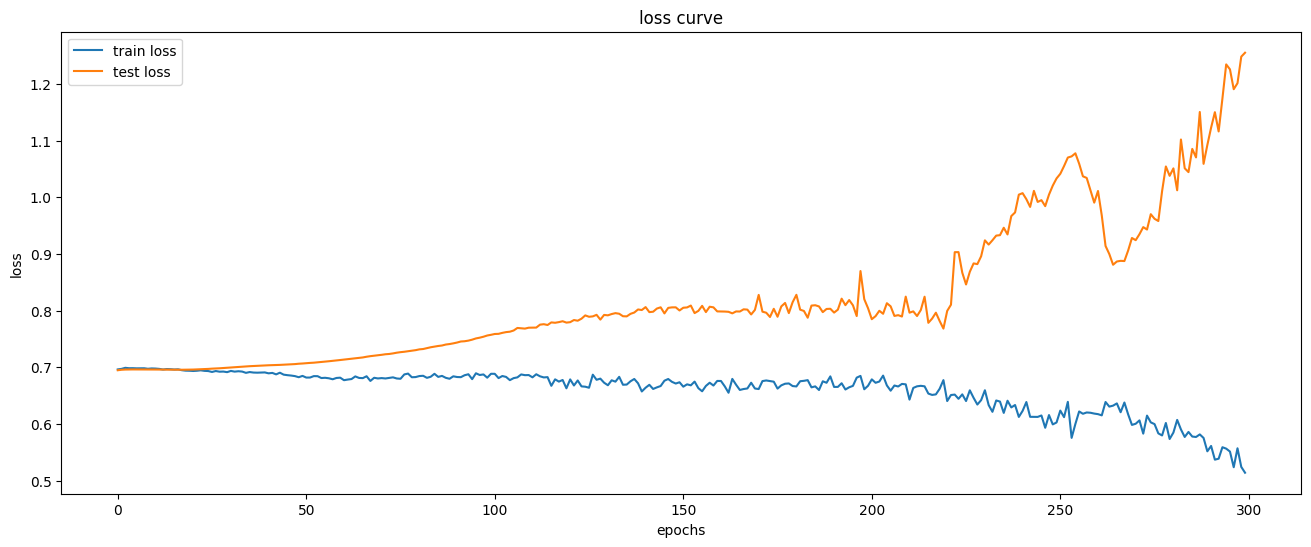

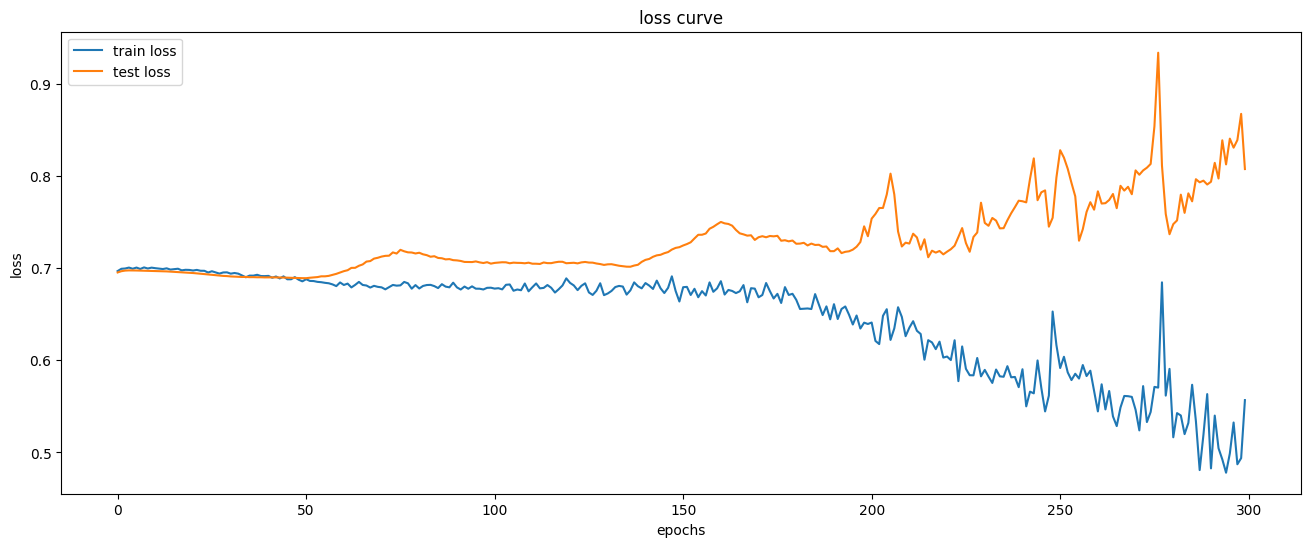

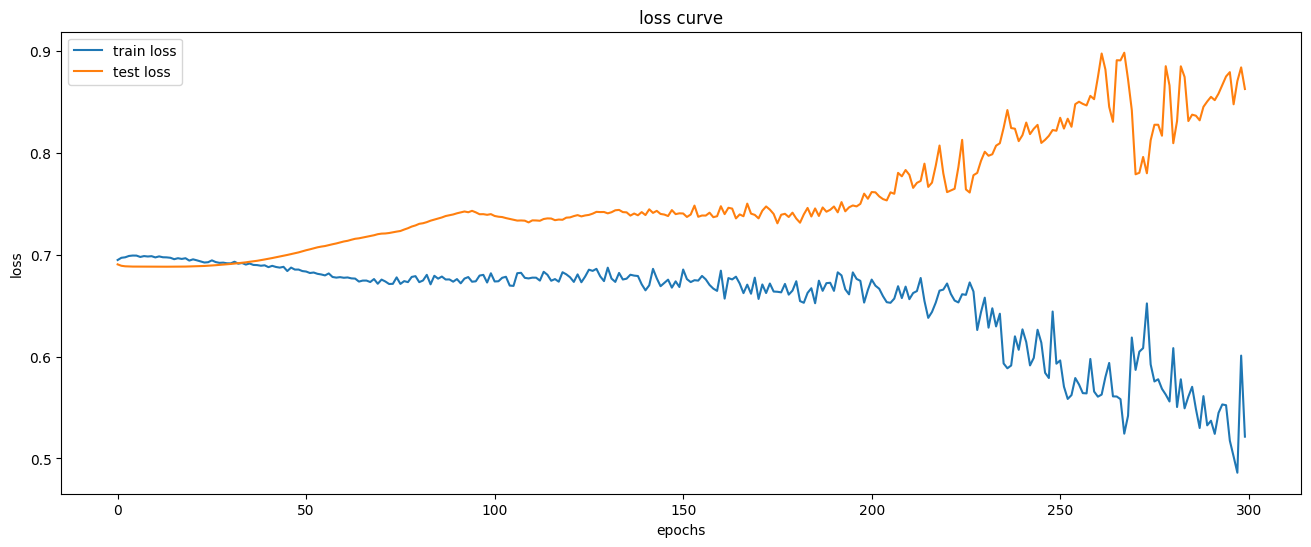

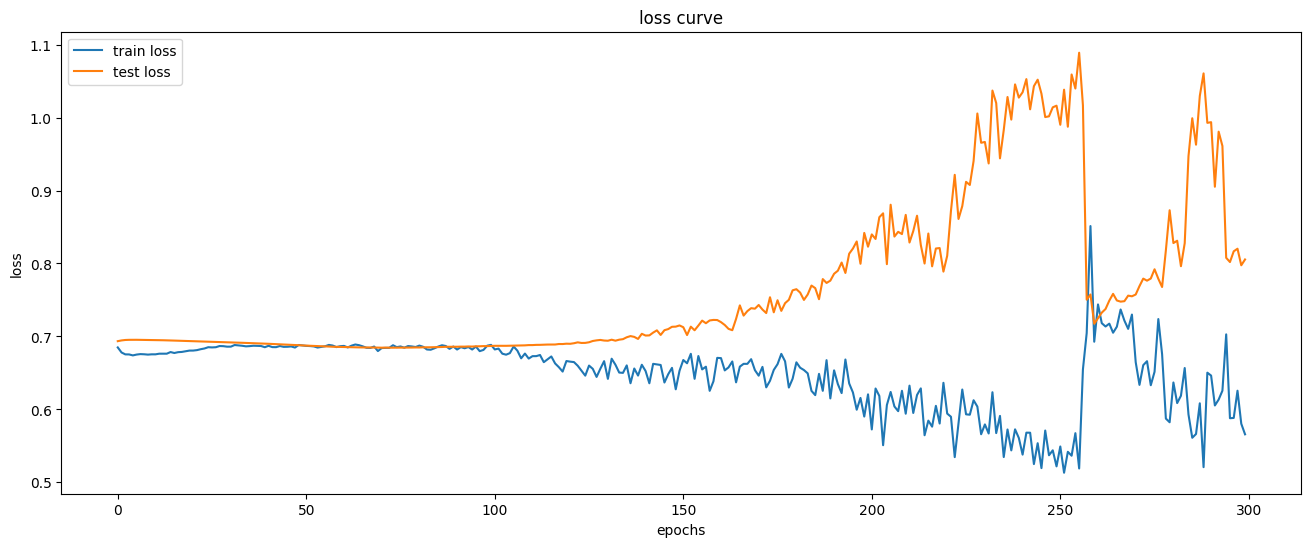

In [36]:
for i in range(len(train_loss_history)):
    plt.figure(figsize=(16,6))
    plt.plot(train_loss_history[i])
    plt.plot(test_loss_history[i])
    plt.legend(['train loss', 'test loss'], loc='upper left')
    plt.title("loss curve")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()